In [1]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#download provided NFL data
#assumes that all files are in the same folder as this file
df_games = pd.read_csv('games.csv')
df_player_play = pd.read_csv('player_play.csv')
df_players = pd.read_csv('players.csv')
df_plays = pd.read_csv('plays.csv')
df_w1 = pd.read_csv('tracking_week_1.csv')
df_w2 = pd.read_csv('tracking_week_2.csv')
df_w3 = pd.read_csv('tracking_week_3.csv')
df_w4 = pd.read_csv('tracking_week_4.csv')
df_w5 = pd.read_csv('tracking_week_5.csv')
df_w6 = pd.read_csv('tracking_week_6.csv')
df_w7 = pd.read_csv('tracking_week_7.csv')
df_w8 = pd.read_csv('tracking_week_8.csv')
df_w9 = pd.read_csv('tracking_week_9.csv')

In [3]:
#concatenate the player tracking dataframes
tracking = pd.concat([df_w1,df_w2,df_w3,df_w4,df_w5,df_w6,df_w7,df_w8,df_w9])

In [4]:
#Function that changes all plays to going in the same direction, and also converts floats to ints to save memory
def standardize_df(df):
    
    #flip the x and y coordinates for plays, so they all go left to right
    df['x_std'] = np.where(
        df["playDirection"] == "left",
        (120 - df["x"].to_numpy()) * 100,
        df["x"].to_numpy() * 100
    ).astype(int)
    df['y_std'] = np.where(
        df["playDirection"] == "left",
        (120 - df["y"].to_numpy()) * 100,
        df["y"].to_numpy() * 100
    ).astype(int)

    #standardize and clean the 'o' column to always go left to right
    df["o_std"] = (-(df["o"] - 90)) % 360
    df["o_std"] = np.where(
        df["playDirection"] == "left",
        (180 - df["o_std"]) % 360,
        df["o_std"]
    )
    df["o_std"] = (df["o_std"] * 100).fillna(0).astype(int) #convert to int
    
    #standardize and clean the 'dir' column to always go left to right
    df["dir_std"] = (-(df["dir"] - 90)) % 360
    df["dir_std"] = np.where(
        df["playDirection"] == "left",
        (180 - df["dir_std"]) % 360, 
        df["dir_std"]
    )
    df["dir_std"] = (df["dir_std"] * 100).fillna(0).astype(int)  #convert to int

    #convert other cells to int
    df['s_std'] = (df['s']*100).astype(int)
    df['a_std'] = (df['a']*100).astype(int)
    df['dis_std'] = (df['dis']*100).astype(int)

    #downcast integer columns to save memory
    df['x_std'] = pd.to_numeric(df['x_std'], downcast='integer')
    df['y_std'] = pd.to_numeric(df['y_std'], downcast='integer')
    df['o_std'] = pd.to_numeric(df['o_std'], downcast='integer')
    df['dis_std'] = pd.to_numeric(df['dis_std'], downcast='integer')
    df['dir_std'] = pd.to_numeric(df['dir_std'], downcast='integer')
    df['s_std'] = pd.to_numeric(df['s_std'], downcast='integer')
    df['a_std'] = pd.to_numeric(df['a_std'], downcast='integer')


In [5]:
#apply to tracking
standardize_df(tracking)

In [6]:
#get all players who did a motion or shift
df_player_play_motion_ids = df_player_play[(df_player_play['motionSinceLineset']) | (df_player_play['shiftSinceLineset'])][['gameId', 'playId', 'nflId']]

#create a dataframe with only tracking data from players who moved
tracking_motion = tracking.merge(df_player_play_motion_ids, on = ['gameId','playId','nflId'], how = 'inner')
#drop unnecessary columns
tracking_motion = tracking_motion.drop(columns=['x', 'y', 's', 'a','dis', 'o', 'dir','time','jerseyNumber','playDirection'])

In [7]:
#remove play found with incorrect labels
tracking_motion = tracking_motion[(tracking_motion['gameId'] != 2022102700) | (tracking_motion['playId'] != 1325)]

In [8]:
#remove kneels, spikes, and plays nullified by penalty
df_plays_simple = df_plays[(df_plays['playNullifiedByPenalty'] == 'N') & (df_plays['qbSpike'] != True) & (df_plays['qbKneel'] != 1)][['gameId', 'playId']]

#remove motions that fall into those categories
tracking_motion = tracking_motion.merge(df_plays_simple, on=['gameId', 'playId'], how='inner')

In [9]:
#calculate the distance from the player to the football

tracking_football = tracking[tracking['displayName'] == 'football'][['gameId','playId','frameId','x_std','y_std']]

tracking_motion = tracking_motion.merge(tracking_football, on = ['gameId','playId','frameId'], suffixes=('','_fb'))

tracking_motion['dis_fb_x'] = tracking_motion['x_std'] - tracking_motion['x_std_fb']
tracking_motion['dis_fb_y'] = tracking_motion['y_std'] - tracking_motion['y_std_fb']

In [10]:
#creates a column of the first frame where the passed event occurred on the specific play
def find_frame_of_event(df, event_name, event_suffix):
    
    #get frameId for every event occurrence per play
    frameIds = df[df['event'] == event_name][['gameId','playId','frameId']].drop_duplicates()

    #get frameId column by merging dataframes
    merged_df = df.merge(frameIds, on=['gameId', 'playId'], suffixes=('', event_suffix))

    return merged_df

#filters the tracking data passed to the frames between 'line_set' and 'ball_snap'
def filter_to_between_line_set_ball_snap(df):

    #filter out any plays where lineset was not marked (ended up removing 0.7% of frames: (1 - len(filtered_tracking_motion) / len(tracking_motion)))
    df_new = (
        df
        .groupby(['gameId', 'playId'])
        .filter(lambda x: (x['event'] == 'line_set').any())
        .reset_index(drop=True)
    )

    #remove frames after ball_snap
    df_new = df_new[df_new['frameType'] != 'AFTER_SNAP']
    
    #add column for frameId when lineset occurred
    filtered_df = find_frame_of_event(df_new, 'line_set', '_ls')
    
    #remove frames before line_snap
    filtered_df = filtered_df[filtered_df['frameId'] >= filtered_df['frameId_ls']]

    #add column for frameId when the ball was snapped
    filtered_df = find_frame_of_event(filtered_df, 'ball_snap', '_bs')

    return filtered_df

In [11]:
tracking_motion_filtered = filter_to_between_line_set_ball_snap(tracking_motion)

In [12]:
#drop frameType column, not needed any more
tracking_simple = tracking_motion_filtered.drop(columns=['frameType'])

In [13]:
#calculate frames before snap (note: a frame is .1 second)
tracking_simple['frames_bf_snap'] = tracking_simple['frameId_bs'] - tracking_simple['frameId']

In [14]:
#make columns of the player's coordinates at the linesnap
tracking_simple.loc[tracking_simple['frameId'] == tracking_simple['frameId_ls'], 'initial_x_std'] = tracking_simple['x_std']
tracking_simple['initial_x_std'] = tracking_simple['initial_x_std'].ffill().astype(int)

tracking_simple.loc[tracking_simple['frameId'] == tracking_simple['frameId_ls'], 'initial_y_std'] = tracking_simple['y_std']
tracking_simple['initial_y_std'] = tracking_simple['initial_y_std'].ffill().astype(int)

#find how far the player has moved from their initial coordinates at every frame
tracking_simple['x_change_all'] = tracking_simple['initial_x_std'] - tracking_simple['x_std']
tracking_simple['y_change_all'] = tracking_simple['initial_y_std'] - tracking_simple['y_std']

In [15]:
#find change in x,y coordinates per frame
tracking_simple['x_change'] = tracking_simple.groupby(['gameId','playId','nflId'])['x_std'].diff().fillna(0).astype(int)
tracking_simple['y_change'] = tracking_simple.groupby(['gameId','playId','nflId'])['y_std'].diff().fillna(0).astype(int)

In [16]:
#create an estimate of how fast a person is in motion, see what the change in y is

#first observe players not in motion/shifting

tracking_avg_movement = tracking.drop(columns=['x', 'y', 's', 'a','dis', 'o', 'dir'])

df_player_play_motion_ids_false = df_player_play[(df_player_play['motionSinceLineset'] == False)&(df_player_play['shiftSinceLineset'] == False)][['gameId','playId','nflId']]
tracking_avg_movement = tracking_avg_movement.merge(df_player_play_motion_ids_false, on = ['gameId','playId','nflId'], how = 'inner')

tracking_avg_movement = filter_to_between_line_set_ball_snap(tracking_avg_movement)
tracking_avg_movement = tracking_avg_movement.drop(columns=['frameType','time', 'jerseyNumber','playDirection','event'])

tracking_avg_movement['x_change'] = tracking_avg_movement.groupby(['gameId','playId','nflId'])['x_std'].diff().fillna(0).astype(int)
tracking_avg_movement['y_change'] = tracking_avg_movement.groupby(['gameId','playId','nflId'])['y_std'].diff().fillna(0).astype(int)

<Axes: xlabel='dis_std', ylabel='Count'>

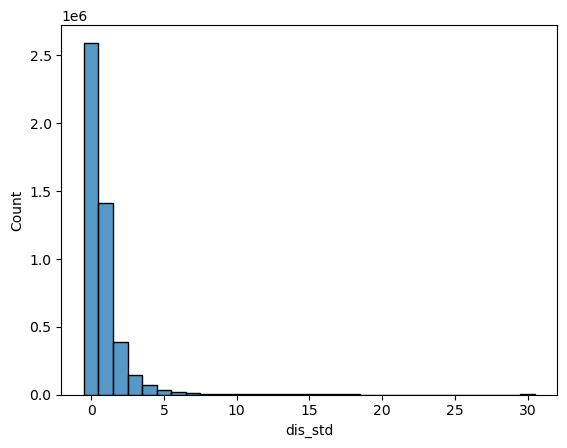

In [17]:
#check average dis_std of someone not in motion/shifting
sns.histplot(tracking_avg_movement['dis_std'].apply(lambda x: min(abs(x), 30)), discrete=True)

In [18]:
tracking_avg_movement['y_change'].describe()

count    4.702742e+06
mean    -2.406681e-03
std      1.619059e+00
min     -1.070000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.460000e+02
Name: y_change, dtype: float64

In [19]:
tracking_avg_movement['y_change'].quantile(.99)

3.0

<Axes: xlabel='dis_std', ylabel='Count'>

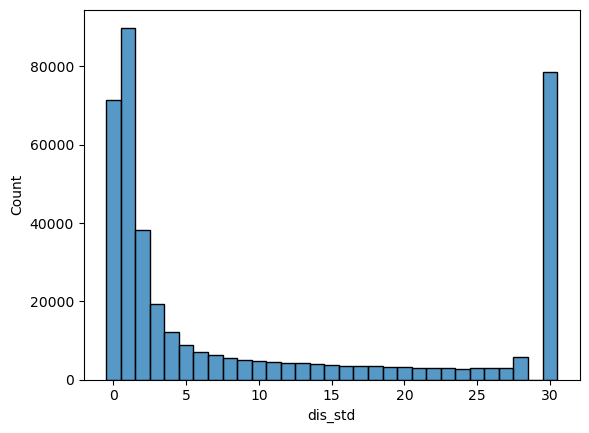

In [20]:
#compare to histograph from players in motion/shift
sns.histplot(tracking_simple['dis_std'].apply(lambda x: min(abs(x), 30)), discrete=True)

In [21]:
#based on above results, mark a player as in motion/shift when their x_change or y_change is 4 or above
tracking_simple['in_motion'] = (tracking_simple['dis_std'].abs() >= 4)*1

In [22]:
# #get tracking data for only linemen (needed in feature creation)
# tracking_snap = tracking[tracking['event'] == 'ball_snap']
# df_players_line = df_players[df_players['position'].isin(['T', 'G', 'C'])][['nflId']]
# tracking_linemen = tracking_snap.merge(df_players_line, on = ['nflId'])[['gameId','playId','frameId','y_std']]

In [23]:
#export csvs for feature creation
tracking_simple.to_csv('tracking_simple.csv',index=False)
tracking_football.to_csv('tracking_football.csv',index=False)
# tracking_linemen.to_csv('tracking_linemen.csv',index=False)

In [24]:
#export csv for motion play visualization
tracking_motion_play_vis = tracking_simple[['gameId','playId','nflId','frameId','in_motion']]
tracking_motion_play_vis.to_csv('tracking_motion_play_vis.csv',index=False)

In [25]:
#export csv for vertical play visualization

tracking_for_vertical = tracking.copy()
tracking_for_vertical = tracking_for_vertical.merge(tracking_football, on = ['gameId','playId','frameId'], suffixes=('','_fb'))

# tracking_for_vertical = tracking_simple[['gameId','playId','nflId','displayName','frameId','club','dis_fb_x','dis_fb_y','s_std','in_motion']]
# tracking_for_vertical['s_std'] = tracking_for_vertical['s_std']/100 #convert speed back to normal units

# #only need players on offense
# df_plays_off = df_plays[['gameId','playId','possessionTeam']]
# tracking_for_vertical = tracking_for_vertical.merge(df_plays_off,on=['gameId','playId'],how='inner')

# #mark players who go into motion
# tracking_for_vertical['in_motion_flag'] = tracking_for_vertical.groupby(['gameId', 'playId', 'nflId'])['in_motion'].transform(lambda x: (x == 1).any())

In [26]:
tracking_for_vertical['dis_fb_x'] = tracking_for_vertical['x_std'] - tracking_for_vertical['x_std_fb']
tracking_for_vertical['dis_fb_y'] = tracking_for_vertical['y_std'] - tracking_for_vertical['y_std_fb']

In [27]:
df_player_play_motion_ids['motion_true'] = 1
tracking_for_vertical_1 = tracking_for_vertical.merge(df_player_play_motion_ids,on=['gameId','playId','nflId'],how='left')
tracking_for_vertical_1['motion_true'] = tracking_for_vertical_1['motion_true'].fillna(0)

#remove defensive players
df_plays_off = df_plays[['gameId','playId','possessionTeam']]
tracking_for_vertical_1 = tracking_for_vertical_1.merge(df_plays_off,on=['gameId','playId'],how='inner')
tracking_for_vertical_1 = tracking_for_vertical_1[tracking_for_vertical_1['club'] == tracking_for_vertical_1['possessionTeam']]

#flag for when a player is in motion
tracking_for_vertical_1['in_motion'] = (tracking_for_vertical_1['dis_std'].abs() >= 4)*1 * tracking_for_vertical_1['motion_true']

tracking_for_vertical_2 = filter_to_between_line_set_ball_snap(tracking_for_vertical_1)



In [28]:
tracking_for_vertical_f = tracking_for_vertical_2[['gameId', 'playId', 'nflId', 'displayName','frameId','s_std','dis_fb_x','dis_fb_y','motion_true','in_motion']]

In [29]:
tracking_for_vertical_f.to_csv('tracking_vertical.csv')

In [30]:
tracking_motion[tracking_motion['gameId'] == 2022090800][['gameId','playId']].drop_duplicates()

,gameId,playId
236657,2022090800,56
236849,2022090800,80
236991,2022090800,101
237140,2022090800,191
237297,2022090800,212
237468,2022090800,236
237622,2022090800,299
238222,2022090800,343
238371,2022090800,364
238595,2022090800,393


In [31]:
tracking_for_vertical_2.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a',
       'dis', 'o', 'dir', 'event', 'x_std', 'y_std', 'o_std', 'dir_std',
       's_std', 'a_std', 'dis_std', 'x_std_fb', 'y_std_fb', 'dis_fb_x',
       'dis_fb_y', 'motion_true', 'possessionTeam', 'in_motion', 'frameId_ls',
       'frameId_bs'],
      dtype='object')